##### Copyright 2022 The TensorFlow Authors.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# 비디오 데이터 로드

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/video"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a></td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/load_data/video.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/load_data/video.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/load_data/video.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드하기</a></td>
</table>

이 튜토리얼은 [UCF101 인간 행동 데이터세트](https://en.wikipedia.org/wiki/Audio_Video_Interleave)를 사용하여 [AVI](https://www.tensorflow.org/datasets/catalog/ucf101){:.external} 비디오 데이터를 로드하고 전처리하는 방법을 보여줍니다. 데이터를 전처리하면 비디오 분류/인식, 캡션 또는 클러스터링과 같은 작업에 사용할 수 있습니다. 원본 데이터세트에는 첼로 연주, 양치질, 눈 화장 등 101개 범주로 YouTube에서 수집한 사실적인 동작 비디오가 포함되어 있습니다. 다음을 수행하는 방법을 배우게 됩니다.

- zip 파일에서 데이터를 로드합니다.

- 비디오 파일에서 프레임 시퀀스를 읽습니다.

- 비디오 데이터를 시각화합니다.

- 프레임 생성기 [`tf.data.Dataset`](https://www.tensorflow.org/guide/data)을 래핑합니다.

## 설정

ZIP 파일의 내용을 검사하기 위한 [remotezip](https://github.com/gtsystem/python-remotezip){:.external}, 진행률 표시줄을 사용하기 위한 [tqdm](https://github.com/tqdm/tqdm){:.external}, 비디오 파일을 처리하기 위한 [OpenCV](https://opencv.org/){:.external}, 및 Jupyter 노트북에 데이터를 내장하기 위한 [`tensorflow_docs`](https://github.com/tensorflow/docs/tree/master/tools/tensorflow_docs){:.external}를 포함해 일부 필요한 라이브러리를 설치하고 가져오는 것으로 시작합니다.

In [1]:
# The way this tutorial uses the `TimeDistributed` layer requires TF>=2.10
!pip install -U "tensorflow>=2.10.0"

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 46.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 31.5 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing i

In [2]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for remotezip: filename=remotezip-0.12.1-py3-none-any.whl size=7947 sha256=539d1c0dda28ad6f6bf6f22f7ee0d06198699b18261c6dd41fae005ff1ee5744
  Stored in directory: /root/.cache/pip/wheels/36/69/50/7b5a7fd4fda1cbb85c080b1c05cbbd2f88ac6a665260910b13
Successfully built remotezip
  Preparing metadata (setup.py) ... done


In [3]:
import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import numpy as np
import remotezip as rz

import tensorflow as tf

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed

## UCF101 데이터세트의 하위 집합 다운로드

[UCF101 데이터세트](https://www.tensorflow.org/datasets/catalog/ucf101)에는 주로 동작 인식에 사용되는 비디오의 다양한 동작이 101개의 범주로 포함되어 있습니다. 이 데모에서 이러한 범주 중 일부를 사용합니다.

In [4]:
URL = 'https://storage.googleapis.com/thumos14_files/UCF101_videos.zip'

위 URL에는 UCF 101 데이터세트가 포함된 zip 파일이 포함되어 있습니다. `remotezip` 라이브러리를 사용하여 해당 URL에 있는 zip 파일의 내용을 검사하는 함수를 만듭니다.

In [5]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with rz.RemoteZip(zip_url) as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [6]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.avi')]
files[:10]

['UCF101/v_ApplyEyeMakeup_g01_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c04.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c05.avi',
 'UCF101/v_ApplyEyeMakeup_g01_c06.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c01.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c02.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c03.avi',
 'UCF101/v_ApplyEyeMakeup_g02_c04.avi']

몇 개의 비디오와 제한된 수의 훈련용 클래스로 시작합니다. 위의 코드 블록을 실행한 후 각 비디오의 파일 이름에 클래스 이름이 포함되어 있음을 확인하세요.

파일 이름에서 클래스 이름을 검색하는 `get_class` 함수를 정의합니다. 그런 다음 모든 파일(위의 `files`) 목록을 각 클래스에 대한 파일을 나열하는 사전으로 변환하는 `get_files_per_class`라는 함수를 만듭니다.

In [7]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  return fname.split('_')[-3]

In [8]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values).
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

클래스별 파일 목록이 준비되면 데이터세트를 만들기 위해 사용할 클래스 수와 클래스당 원하는 비디오 수를 선택할 수 있습니다. 

In [9]:
NUM_CLASSES = 10
FILES_PER_CLASS = 50

In [10]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

In [11]:
print('Num classes:', len(classes))
print('Num videos for class[0]:', len(files_for_class[classes[0]]))

Num classes: 101
Num videos for class[0]: 145


데이터세트 내에 있는 클래스의 하위 집합과 클래스당 특정 수의 파일을 선택하는 `select_subset_of_classes`라는 새 함수를 만듭니다.

In [12]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [13]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['ApplyEyeMakeup',
 'ApplyLipstick',
 'Archery',
 'BabyCrawling',
 'BalanceBeam',
 'BandMarching',
 'BaseballPitch',
 'BasketballDunk',
 'Basketball',
 'BenchPress']

비디오를 훈련, 검증 및 테스트 세트로 분할하는 헬퍼 함수를 정의합니다. 비디오는 zip 파일로 URL에서 다운로드되어 각각의 하위 디렉터리에 배치됩니다.

In [14]:
def download_from_zip(zip_url, to_dir, file_names):
  """ Download the contents of the zip file from the zip URL.

    Args:
      zip_url: A URL with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to download.
  """
  with rz.RemoteZip(zip_url) as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

다음 함수는 데이터의 하위 집합에 아직 배치되지 않은 나머지 데이터를 반환합니다. 이 나머지 데이터를 지정된 다음 데이터 하위 집합에 배치할 수 있습니다.

In [15]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

다음 `download_ufc_101_subset` 함수를 사용하면 UCF101 데이터세트의 하위 집합을 다운로드하고 훈련, 검증 및 테스트 세트로 분할할 수 있습니다. 사용하려는 클래스 수를 지정할 수 있습니다. `splits` 인수를 사용하면 키 값이 하위 집합의 이름(예: "train")과 클래스당 가지려는 비디오 수인 사전을 전달할 수 있습니다.

In [16]:
def download_ufc_101_subset(zip_url, num_classes, splits, download_dir):
  """ Download a subset of the UFC101 dataset and split them into various parts, such as
    training, validation, and test.

    Args:
      zip_url: A URL with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data 
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
    if len(tokens) <= 2:
      files.remove(f) # Remove that item from the list if it does not have a filename
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    download_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [18]:
download_dir = pathlib.Path('./UCF101_subset/')
subset_paths = download_ufc_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 30, "val": 10, "test": 10},
                                       download_dir = download_dir)

train :


100%|██████████| 300/300 [06:38<00:00,  1.33s/it]


val :


100%|██████████| 100/100 [02:15<00:00,  1.35s/it]


test :


100%|██████████| 100/100 [02:30<00:00,  1.50s/it]


데이터를 다운로드한 후에는 이제 UCF101 데이터세트의 하위 집합 복사본이 있어야 합니다. 다음 코드를 실행하여 모든 데이터 하위 집합 사이에 가지고 있는 총 비디오 수를 인쇄합니다.

In [19]:
video_count_train = len(list(download_dir.glob('train/*/*.avi')))
video_count_val = len(list(download_dir.glob('val/*/*.avi')))
video_count_test = len(list(download_dir.glob('test/*/*.avi')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 500


이제 데이터 파일의 디렉터리를 미리 볼 수도 있습니다.

In [20]:
!find ./UCF101_subset

./UCF101_subset
./UCF101_subset/train
./UCF101_subset/train/Archery
./UCF101_subset/train/Archery/v_Archery_g07_c05.avi
./UCF101_subset/train/Archery/v_Archery_g09_c02.avi
./UCF101_subset/train/Archery/v_Archery_g02_c05.avi
./UCF101_subset/train/Archery/v_Archery_g12_c01.avi
./UCF101_subset/train/Archery/v_Archery_g20_c01.avi
./UCF101_subset/train/Archery/v_Archery_g02_c07.avi
./UCF101_subset/train/Archery/v_Archery_g14_c02.avi
./UCF101_subset/train/Archery/v_Archery_g02_c03.avi
./UCF101_subset/train/Archery/v_Archery_g10_c05.avi
./UCF101_subset/train/Archery/UCF101
./UCF101_subset/train/Archery/v_Archery_g01_c02.avi
./UCF101_subset/train/Archery/v_Archery_g23_c07.avi
./UCF101_subset/train/Archery/v_Archery_g23_c03.avi
./UCF101_subset/train/Archery/v_Archery_g18_c06.avi
./UCF101_subset/train/Archery/v_Archery_g08_c05.avi
./UCF101_subset/train/Archery/v_Archery_g09_c04.avi
./UCF101_subset/train/Archery/v_Archery_g17_c02.avi
./UCF101_subset/train/Archery/v_Archery_g19_c03.avi
./UCF101_su

## 각 비디오 파일에서 프레임 만들기

`frames_from_video_file` 함수는 비디오를 여러 프레임으로 분할하고 비디오 파일에서 무작위로 선택된 `n_frames` 범위를 읽은 다음, NumPy `array`로 반환합니다. 메모리와 계산 오버헤드를 줄이려면 **적은** 수의 프레임을 선택합니다. 또한 각 비디오에서 **동일한** 수의 프레임을 선택하면 데이터 배치 작업을 더 쉽게 수행할 수 있습니다.


In [21]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [22]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 15):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

## 비디오 데이터 시각화하기

프레임 세트를 NumPy 배열로 반환하는 `frames_from_video_file` 함수입니다. Patrick Gillett가 [Wikimedia](https://commons.wikimedia.org/wiki/Category:Videos_of_sports){:.external}에 올린 새 동영상에서 이 기능을 사용해 보세요.

In [23]:
!curl -O https://upload.wikimedia.org/wikipedia/commons/8/86/End_of_a_jam.ogv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 55.0M  100 55.0M    0     0  8853k      0  0:00:06  0:00:06 --:--:-- 12.3M


In [24]:
video_path = "End_of_a_jam.ogv"

In [25]:
sample_video = frames_from_video_file(video_path, n_frames = 10)
sample_video.shape

(10, 224, 224, 3)

In [26]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


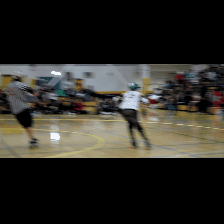

In [27]:
to_gif(sample_video)

이 비디오를 검토하는 외에 UCF-101 데이터를 표시할 수도 있습니다. 이렇게 하려면 다음 코드를 실행합니다.


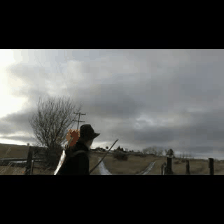

In [28]:
# docs-infra: no-execute
ucf_sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.avi')), 50)
to_gif(ucf_sample_video)

다음으로, TensorFlow 데이터 파이프라인에 데이터를 공급할 수 있는 반복 가능한 객체를 생성하기 위해 `FrameGenerator` 클래스를 정의합니다. 생성기(`__call__`) 함수는 `frames_from_video_file`에 의해 생성된 프레임 배열과 프레임 세트와 연관된 레이블의 원-핫 인코딩된 벡터를 생성합니다.

In [29]:
class FrameGenerator:
  def __init__(self, path, n_frames):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        classes: List of labels for classification.
    """
    self.path = path
    self.n_frames = n_frames
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.avi'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

TensorFlow Dataset 객체로 래핑하기 전에 `FrameGenerator` 객체를 테스트합니다.

In [30]:
fg = FrameGenerator(subset_paths['train'], 10)

frames, label = next(fg())

print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Shape: (10, 224, 224, 3)
Label: 1


마지막으로, TensorFlow 데이터 입력 파이프라인을 만듭니다. 생성기 객체에서 생성하는 이 파이프라인을 사용하면 딥 러닝 모델에 데이터를 공급할 수 있습니다. 이 비디오 파이프라인에서 각 요소는 단일 프레임 세트 및 관련 레이블입니다.

In [31]:
# Create the training set
output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))
train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], 10),
                                          output_signature = output_signature)

In [32]:
# Create the validation set
val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], 10),
                                        output_signature = output_signature)

In [33]:
# Print the shapes of the data
train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (10, 224, 224, 3)
Shape of training labels: ()
Shape of validation set of frames: (10, 224, 224, 3)
Shape of validation labels: ()


## 성능을 높이기 위해 데이터세트 구성하기

I/O가 차단되지 않고 디스크에서 데이터를 생성할 수 있도록 버퍼링된 프리페치를 사용합니다. 데이터를 로드하는 동안 사용해야 하는 두 가지 중요한 함수는 다음과 같습니다.

- `Dataset.cache`: 첫 번째 epoch 동안 디스크에서 로드된 후 프레임 세트를 메모리에 유지합니다. 이 함수는 모델을 훈련하는 동안 데이터세트가 병목을 일으키지 않도록 합니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우 이 방법을 사용하여 고성능 디스크 캐시를 생성할 수도 있습니다.

- `Dataset.prefetch`: 훈련하는 동안 데이터 전처리와 모델 실행을 중첩시킵니다. 자세한 내용은 [`tf.data`로 성능 향상](https://www.tensorflow.org/guide/data_performance)을 참조하세요.

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)

모델에 공급할 데이터를 준비하려면 아래와 같이 배치 처리를 사용합니다. AVI 파일과 같은 비디오 데이터로 작업할 때 데이터는 5차원 객체로 형성되어야 합니다. 이러한 차원은 `[batch_size, number_of_frames, height, width, channels]`와 같습니다. 이에 비해 이미지에는 `[batch_size, height, width, channels]` 4가지 차원이 있습니다. 아래 이미지는 비디오 데이터의 형태가 표현되는 방식을 보여주는 그림입니다.

![비디오 데이터 형태](https://www.tensorflow.org/images/tutorials/video/video_data_shape.png)


In [35]:
train_ds = train_ds.batch(2)
val_ds = val_ds.batch(2)

train_frames, train_labels = next(iter(train_ds))
print(f'Shape of training set of frames: {train_frames.shape}')
print(f'Shape of training labels: {train_labels.shape}')

val_frames, val_labels = next(iter(val_ds))
print(f'Shape of validation set of frames: {val_frames.shape}')
print(f'Shape of validation labels: {val_labels.shape}')

Shape of training set of frames: (2, 10, 224, 224, 3)
Shape of training labels: (2,)
Shape of validation set of frames: (2, 10, 224, 224, 3)
Shape of validation labels: (2,)


## 다음 단계

레이블이 있는 비디오 프레임의 TensorFlow `Dataset`을 만들었으므로 이제 딥 러닝 모델에 이를 사용할 수 있습니다. 사전 훈련된 [EfficientNet](https://arxiv.org/abs/1905.11946){:.external}을 사용하는 다음 분류 모델은 몇 분 안에 높은 정확도로 훈련됩니다.

In [36]:
net = tf.keras.applications.EfficientNetB0(include_top = False)
net.trainable = False

model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=255),
    tf.keras.layers.TimeDistributed(net),
    tf.keras.layers.Dense(10),
    tf.keras.layers.GlobalAveragePooling3D()
])

model.compile(optimizer = 'adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True),
              metrics=['accuracy'])

model.fit(train_ds, 
          epochs = 10,
          validation_data = val_ds,
          callbacks = tf.keras.callbacks.EarlyStopping(patience = 2, monitor = 'val_loss'))

16705208/16705208 [==============================] - 2s 0us/step
Epoch 1/10
150/150 [==============================] - 34s 75ms/step - loss: 1.2016 - accuracy: 0.6833 - val_loss: 0.5083 - val_accuracy: 0.9400
Epoch 2/10
150/150 [==============================] - 8s 55ms/step - loss: 0.3366 - accuracy: 0.9633 - val_loss: 0.3072 - val_accuracy: 0.9600
Epoch 3/10
150/150 [==============================] - 8s 55ms/step - loss: 0.1844 - accuracy: 0.9867 - val_loss: 0.2452 - val_accuracy: 0.9700
Epoch 4/10
150/150 [==============================] - 8s 55ms/step - loss: 0.1223 - accuracy: 0.9967 - val_loss: 0.2118 - val_accuracy: 0.9700
Epoch 5/10
150/150 [==============================] - 8s 55ms/step - loss: 0.0827 - accuracy: 1.0000 - val_loss: 0.1993 - val_accuracy: 0.9500
Epoch 6/10
150/150 [==============================] - 8s 56ms/step - loss: 0.0627 - accuracy: 1.0000 - val_loss: 0.1821 - val_accuracy: 0.9600
Epoch 7/10
150/150 [==============================] - 8s 56ms/step - loss: 0